In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import nbimporter
import Commons as commons
import time

%matplotlib inline

'''******************************
*   Variable Initializations    *
******************************'''

NX = 30                                                        # X dimension
NY = 30                                                        # Y dimension
omega = 1                                                      # The relaxation time 1/T
w_i = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]        # Weights
c_ij = np.array([[0,0],                                        # Velocity vector for different positions
                 [1,0],
                 [0,1],
                 [-1,0],
                 [0,-1],
                 [1,1],
                 [-1,1],
                 [-1,-1],
                 [1,-1]])
nu = 1/3 * (1/omega - 1/2)                                      # Kinetic viscousity
iterations = 5501                                              # No. of iterations

# Add 2 extra rows
NX = NX + 2
NY = NY + 2

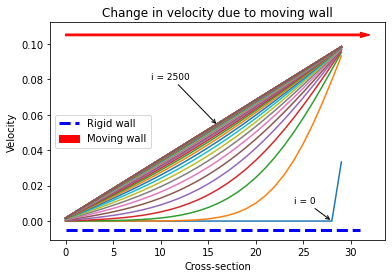

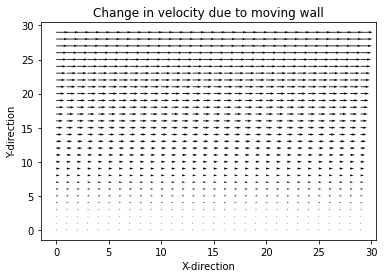

In [11]:
'''******************************
#          Couette Flow         *
******************************'''
# Initialise variables
rho_ij = np.ones([NY, NX])
u_ijk = np.zeros([2, NY, NX])
u_wall = [0.1, 0.]                         # Velocity on top boundary in x direction

# Initialize probability distribution
f_ijk = commons.calc_feq(w_i, c_ij, rho_ij, u_ijk, NY, NX)

count = 1
fig, ax = plt.subplots()
startTime = time.time()
ax.set(title='Change in velocity due to moving wall', xlabel='Cross-section', ylabel='Velocity')

# To show the moving wall location
lines = plt.arrow(0, 0.105, NX-1, 0, label="Moving wall", color="r",head_length=1)     
plt.legend()
# To show the moving wall location
lines = plt.plot(np.arange(NX), np.zeros(NX) - 0.005, label="Rigid wall", color="b", linewidth=3, linestyle="--")
plt.legend()

for i in np.arange(iterations):
    # Calculate the rho_wall before streaming (uy=0 and thus we have rho_wall=f0+f1+f3+2*(f2+f5+f6))
    rho_wall = f_ijk[0,:,-2]+f_ijk[1,:,-2]+2.*f_ijk[2,:,-2]+f_ijk[3,:,-2]+2.*f_ijk[5,:,-2]+2.*f_ijk[6,:,-2]
    # Streaming
    f_ijk = commons.streaming(f_ijk, c_ij)
    # Bounce back
    f_ijk = commons.bounce_back(f_ijk, True, False, u_wall, rho_wall, w_i, c_ij)
    # Collision
    f_ijk, rho_ij, u_ijk = commons.collision(f_ijk, c_ij, w_i, omega)
    # Plot and save the graph as a gif
    if i % 100 == 0:
        print('{} iterations in {} time'.format(i, time.time() - startTime), end="\r")
        lines = plt.plot(u_ijk[0,5,1:-1])
        if i == 0:
            ax.annotate('i = 0', xy=(NX - 4, 0.0), xytext=(NX - 8, 0.01), fontsize=9,
                arrowprops=dict(facecolor='black', arrowstyle='->'))
        if i == 2500:
            ax.annotate('i = 2500', xy=(NX // 2, 0.054), xytext=((NX // 2)-7, 0.08), fontsize=9,
                arrowprops=dict(facecolor='black', arrowstyle='->'))

# Quiver plot
Y, X = np.mgrid[0:NY-2,0:NX-2]
fig1, ax1 = plt.subplots()
ax1.set(title='Change in velocity due to moving wall',xlabel='X-direction', ylabel='Y-direction')
q = ax1.quiver(Y, X, u_ijk[0,1:-1,1:-1], u_ijk[1,1:-1,1:-1])
plt.show()


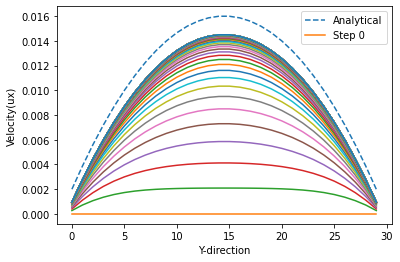

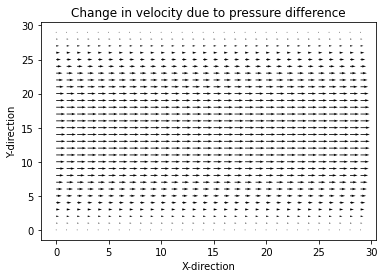

In [3]:
'''******************************
#        Poiseuille Flow        *
******************************'''
# Initialise variables
rho_ij = np.ones([NY, NX])
u_ijk = np.zeros([2, NY, NX])
u_wall = [0., 0.]                         # Velocity on top boundary in x direction
epsilon = 0.001                           # Pressure change
pin = 1. + epsilon                        # Inlet pressure
pout = 1. - epsilon                       # Outlet pressure
X, Y = np.mgrid[0:NY-2,0:NX-2]            # Meshgrid for plotting
fig, ax = plt.subplots()
lines = fig
startTime = time.time()                   # Starting Timestep
ax.set(title='',xlabel='Y-direction', ylabel='Velocity(ux)')

# The Analytical part
# Since our rho is 1 initially, the dynamic and kinematic viscostiy are essentially the same
y = np.linspace(0,NY,NY)
ux_y = (2*epsilon/NX/nu/2) * y * (NY-y)/3
lines = plt.plot(ux_y[1:-1], label="Analytical", linestyle="--")
plt.legend()

# Initialize probability distribution
f_ijk = commons.calc_feq(w_i, c_ij, rho_ij, u_ijk, NY, NX)

for i in np.arange(iterations):
    # Periodic boundary conditions with Pressure variance
    f_ijk[:, 0, :], f_ijk[:, -1, :] = commons.PBC(f_ijk, w_i, c_ij, pin, pout, u_ijk)
    # Streaming
    f_ijk = commons.streaming(f_ijk, c_ij)
    # Bounce back
    f_ijk = commons.bounce_back(f_ijk, False, True)
    # Collision
    f_ijk, rho_ij, u_ijk = commons.collision(f_ijk, c_ij, w_i, omega)
    # Plot the graph
    if i % 5500 == 0:
        print('{} iterations in {} time'.format(i, time.time() - startTime), end="\r")
        if i == 5500:
            lines = plt.plot(u_ijk[0,5,1:-1], label="Step {}".format(i), color="black")
        else:
            lines = plt.plot(u_ijk[0,5,1:-1], label="Step {}".format(i))
        plt.legend()
    elif i % 100 == 0:
        lines = plt.plot(u_ijk[0,5,1:-1])

# The quiver plot to visualize the flow
fig1, ax1 = plt.subplots()
ax1.set(title='Change in velocity due to pressure difference',xlabel='X-direction', ylabel='Y-direction')
q = ax1.quiver(X, Y, u_ijk[0,1:-1,1:-1], u_ijk[1,1:-1,1:-1])
plt.show()